In [12]:
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import matplotlib.pyplot as plt
import os

In [13]:
def import_dataset(split_percent = 70):
    # dataset = pd.read_csv('E:\ELL_Project\problem2\weather_data.csv') 
    pwd = os.getcwd()+'\\weather_data.xlsx'
    dataset = pd.read_excel(pwd)                          
    dataset = dataset.sample(frac = 1)
    X = dataset.iloc[:,:-1].values
    y = dataset.iloc[:,-1:].values
    datasize = X.shape[0]

    split_point = split_percent//10

    X_train = X[:(datasize*split_point)//10,:]
    y_train = y[:(datasize*split_point)//10,:]
    X_test = X[(datasize*split_point)//10:,:]
    y_test = y[(datasize*split_point)//10:,:]

    return(X_train,X_test,y_train,y_test)


In [3]:
# def feature_scaling( X_train ):
#     X_mean = np.sum(X_train,axis=0)
#     X_var = np.sqrt(np.sum(np.square(X_train - X_mean), axis=0))

#     X_train_feat_scaled = (X_train - X_mean ) / X_var
#     # X_test_feat_scaled = (X_test - X_mean) / X_var

#     return (X_mean,X_var, X_train_feat_scaled)

In [4]:
def gradDesc(X,y,theta,hypothesis,loss_function,regularizer,alpha):
    h,loss,gradient = loss_function(X,theta,y,hypothesis)
    reg_loss,reg_grad = regularizer(alpha,theta)
    loss += reg_loss
    gradient += reg_grad

    return(loss,gradient)

In [5]:
def lin_hyp(X,theta):
    return (np.dot(X,theta))

In [44]:
def null_regularizer(alpha,theta):
    a = np.zeros(theta.shape)
    return(a,a)

In [43]:
def l1_reg(alpha,theta):
    reg_loss = alpha*theta
    reg_grad = alpha
    return(reg_loss,reg_grad)

In [8]:
def l2_reg(alpha,theta):
    reg_loss = alpha * np.square(theta)
    reg_grad = 2 * alpha * theta
    return(reg_loss,reg_grad)

In [9]:
def elastic_net_reg(lambda1,lambda2,theta):
    a1,a2 = l1_reg(lambda1,theta)
    b1,b2 = l2_reg(lambda2,theta)
    return( a1+b1 , a2+b2 )

In [11]:
def mse_loss(X,theta,y,hypothesis):
    siz = y.shape[0]
    h = hypothesis(X,theta)
    diff = h-y
    mse = ( np.sum(np.square(diff),axis=0))[0] / siz
    gradient = np.dot(np.transpose(X),diff) / siz

    return(h,mse,gradient)


In [10]:
def mae_loss(X,theta,y,hypothesis):
    siz = y.shape[0]
    num_feat = y.shape[1]

    h = hypothesis(X,theta)
    diff = h-y
    diff_sign = np.ones((siz,1))
    diff_sign[diff[:,0]<0] = -1

    mae = np.sum(np.abs(h),axis=0)[0] / siz
    gradient = np.sum(diff_sign*X,axis=0) / siz

    return(h,mae,gradient)



In [12]:
def ce_loss(X,theta,y,hypothesis):
    siz = y.shape[0]

    h = hypothesis(X,theta)
    h_comp = 1-h
    diff = h - y

    ce = np.sum(-y*log(h)-(1-y)*log(1-h),axis=0) [0] / siz
    gradient = np.dot(np.transpose(X),diff) / siz

    return(h,ce,gradient)   

In [28]:
def linReg(X,y,iter=100,alpha=0.01,batchSize=32):
    # print(X.shape)
    theta = np.random.random((X.shape[1],1))
    # print(theta)
    datasize = X.shape[0]
    loss_epoch,_ = gradDesc(X,y,theta,lin_hyp,mse_loss,l2_reg,alpha)
    for i in range(iter+1):
        if((i)%100000==0):
            print('Loss for {} iterations: {}'.format(i,np.sum(loss_epoch,axis=0)[0]))
        fro = 0
        loss_epoch = 0
        while(True):
            to = min(fro+batchSize,datasize)
            l,theta_grad = gradDesc(X[fro:to,:],y[fro:to,:],theta,lin_hyp,mse_loss,null_regularizer,alpha)
            loss_epoch += l
            theta -= (alpha*theta_grad)
            fro = to

            if(to>=datasize):
                break
    
    return (theta,loss_epoch)

In [29]:
def feature_scaling(X_train):
    training_size = X_train.shape[0]
    X_mean = np.sum(X_train,axis=0) / training_size
    X_var = np.sqrt(np.sum((np.square(X_train-X_mean)),axis=0)/training_size)
    X_train_reg = (X_train - X_mean) / X_var
    return (X_mean,X_var,X_train_reg)

In [30]:
def poly_feat(X,degree=2):
    num_feats = X.shape[1]
    num_vals = X.shape[0]
    X_cross = np.append(np.ones(X.shape),X,axis=1)
    if(degree==0):
        return(np.ones(X.shape))
    if(degree<2):
        return(X_cross)
    for i in range(num_feats):
        for j in range(i+1,num_feats):
            X_cross = np.append( X_cross ,  np.multiply ( X[:,i:i+1] , X[:,j:j+1] ) , axis=1 )
    for i in range(3,degree):
        X_power = np.power(X,i)
        X_cross = np.append(X_cross,X_power,axis=1)

    return ( X_cross )

In [31]:
def polyReg(X,y,iter=100,alpha=0.01,batchSize=32,degree=2):
    X_mean,X_var,X_norm = feature_scaling(X)
    X_cross = poly_feat(X_norm,degree)
    train_size = X_cross.shape[0]
    X_cross = np.append(np.ones((train_size,1)),X_cross,axis=1)
    opt, tl = linReg(X_cross,y,iter=iter,alpha=alpha,batchSize=batchSize)
    return ( X_mean, X_var, opt , tl )


In [32]:
# train_datasize = X_train.shape[0]
# X_mean, X_var, opt_theta, train_loss = polyReg(X_train,y_train,200000,0.01,train_datasize,6)
# print(X_mean.shape)
# print(opt_theta)

In [45]:
def predicter(X_mean, X_var, X_test, opt_theta,degree=2):
    X_test_norm = (X_test - X_mean) / X_var
    X_test_cross = poly_feat(X_test_norm,degree)
    test_size = X_test_cross.shape[0]
    X_test_cross = np.append( np.ones((test_size,1)) , X_test_cross , axis=1)

    # print(X_test_cross.shape)
    # print(opt_theta.shape)
    y_pred = np.dot(X_test_cross, opt_theta)

    return y_pred


In [46]:
def accuracy_metrics_classif(X_mean,X_var,X_test,y_test,opt_theta,degree=2):
    y_pred = predicter(X_mean, X_var, X_test, opt_theta, degree)
    loss_y = y_pred - y_test

    test_size = y_pred.shape[0]
    total_loss_y = np.dot(np.ones((1,test_size)),np.square(loss_y))[0,0] / test_size

    # print(total_loss_y)

    y_pred_thresh = y_pred>=0.5

    tp = np.sum((y_pred_thresh+y_test)==2 , axis=0)[0]
    tn = np.sum(y_pred_thresh==y_test , axis=0)[0] - tp
    fp = np.sum(y_pred_thresh , axis=0)[0]-tp
    fn = test_size-tp-tn-fp


    print('tp: {} , tn: {} , fp: {} , fn: {}'.format(tp,tn,fp,fn))

    acc = (tp+tn)/test_size
    prec = (tp)/(tp+fp)
    recl = (tp)/(tp+fn)
    f1 = 2*prec*recl/(prec+recl)

    print('Accuracy: {}'.format( acc  ))
    print('Precision: {}'.format( prec  ))
    print('Recall: {}'.format( recl  ))
    print('F1 score: {}'.format( f1  ))




In [47]:
def print_accuracy_metric_classif(X_mean,X_var,X_train,X_test,y_train,opt_theta,degree=2):
    print('Train Accuracy')
    accuracy_metrics_classif(X_mean,X_var,X_train,y_train,opt_theta,degree)

    print('..............................................')

    print('Test Accuracy')
    accuracy_metrics_classif(X_mean,X_var,X_test,y_test,opt_theta,degree)

In [48]:
def calc_loss(y_pred,y_test):
    return(np.sum(np.square(y_pred-y_test),axis=0)[0] / y_pred.shape[0])

In [49]:
def plotter(y_test,y_pred):
    siz = y_test.shape[0]
    x_plot = np.arange(0, siz, 1)
    # print(x_plot[:10])
    plt.plot(x_plot, y_pred, 'g')
    plt.plot(x_plot, y_test, 'b')
    plt.show()

In [50]:
def model_run(X_train,X_test,y_train,y_test,degree = 3, plot = False,alpha=0.001):
    # X_mean,X_var, X_train_feat_scaled = feature_scaling(X_train , X_test)
    train_datasize = X_train.shape[0]
    X_mean, X_var, opt_theta, train_loss = polyReg(X_train,y_train,20000,alpha,train_datasize,degree)
    y_pred = predicter(X_mean, X_var, X_test, opt_theta,degree)
    if(plot):
        plotter(y_pred,y_test)
        y_pred_train = predicter(X_mean, X_var, X_train, opt_theta, degree)
        plotter(y_pred_train,y_train)
    return(X_mean, X_var,opt_theta, degree,y_pred)
# print_accuracy_metric_classif(X_mean,X_var,X_train,X_test,y_train,opt_theta,degree=2)

Loss for 0 iterations: 1303.568332732702
Loss for 0 iterations: 2428.951988289015
Loss for 0 iterations: 5797.342484630228
Loss for 0 iterations: 5545.5062066856535
Loss for 0 iterations: 5592.902939076687
Loss for 0 iterations: 5843.851216472166
Loss for 0 iterations: 43658.43531468766
Loss for 0 iterations: 1591222.66616013
Loss for 0 iterations: 7597496.579853869
Loss for 0 iterations: 105443810.86251271


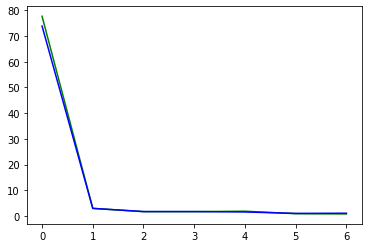

In [51]:
X_train,X_test,y_train,y_test = import_dataset()
pow_l,train_l,test_l = [],[],[]
for power in range(0,10):
    X_mean, X_var,opt_theta, degree,y_pred = model_run(X_train,X_test,y_train,y_test,power,False)
    y_pred_train = predicter(X_mean, X_var, X_train, opt_theta, power)
    l_train = calc_loss(y_pred_train,y_train)
    y_pred_test = predicter(X_mean, X_var, X_test, opt_theta, power)
    if power==10:
        print('CHECK',y_pred_test[:15,:])
    l_test = calc_loss(y_pred_test,y_test)
    pow_l.append(power)
    train_l.append(l_train)
    test_l.append(l_test)
plt.plot(pow_l, test_l, 'g')
plt.plot(pow_l, train_l, 'b')
plt.show()


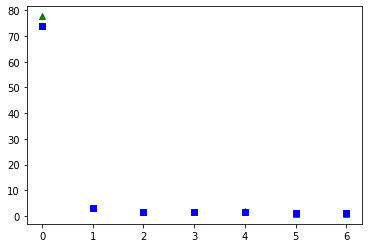

In [52]:
plt.plot(pow_l, test_l, 'g^')
plt.plot(pow_l, train_l, 'bs')
plt.show()

In [26]:
print(pow_l)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]


In [27]:
print(train_l)

[74.72847520717809, 3.0847722329582976, 1.704273649463873, 1.704284807122762, 1.6123004155387526, 1.0248064474293872, 1.0545841439439638, nan, nan, nan]
